In [1]:
import re
import string
import json
import os
import shutil
from pprint import pprint
from functools import partial
from operator import itemgetter, attrgetter
from os.path import normpath
from typing import Callable

import joblib
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns

import dask
import dask.dataframe as dd

# Set Seaborn theme and default palette
sns.set_theme(font_scale=1.25, style="darkgrid")
sns.set_palette("deep", desat=0.85, color_codes=True)

# Turn on inline plotting
%matplotlib inline

# Load Black auto-formatter
%load_ext nb_black

# Enable automatic reloading
%load_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>

In [2]:
# Import my modules
from tools import cleaning, plotting, language as lang, outliers, utils

# Set my default MPL settings
plt.rcParams.update(plotting.MPL_DEFAULTS)

dask.config.set(scheduler="processes")

<IPython.core.display.Javascript object>

# Initial Pruning

In [3]:
cols = ["description", "main_cat", "asin"]
df = dd.read_parquet("data/amazon", engine="pyarrow", columns=cols)
df = df.dropna(subset=["description", "main_cat"])
df

,description,main_cat,asin
npartitions=151,,,
,object,object,object
,...,...,...
...,...,...,...
,...,...,...
,...,...,...


<IPython.core.display.Javascript object>

In [4]:
df.head()

,description,main_cat,asin
0,[(=^ ^=) 1.It is made of high quality material...,Movies & TV,6305121869
1,"[<b><br>Hi friend, welcome to our store. Befor...","<img src=""https://images-na.ssl-images-amazon....",6318708057
2,[Gaok men's pants are all made from cotton mat...,"<img src=""https://images-na.ssl-images-amazon....",6342506256
3,[<b>pant size(Unit:inch)</b><br> W30(tag30) Wa...,"<img src=""https://images-na.ssl-images-amazon....",6342509379
4,[All of our sunglasses offer protection agains...,Sports & Outdoors,6342522081


<IPython.core.display.Javascript object>

In [5]:
# df.to_parquet(
#     "data/init_dropna",
#     engine="pyarrow",
#     schema="infer",
#     overwrite=True,
# )

<IPython.core.display.Javascript object>

In [6]:
# df = dd.read_parquet("data/init_dropna", engine="pyarrow").compute()
# df

<IPython.core.display.Javascript object>

In [7]:
df = df.compute()
df

,description,main_cat,asin
0,[(=^ ^=) 1.It is made of high quality material...,Movies & TV,6305121869
1,"[<b><br>Hi friend, welcome to our store. Befor...","<img src=""https://images-na.ssl-images-amazon....",6318708057
2,[Gaok men's pants are all made from cotton mat...,"<img src=""https://images-na.ssl-images-amazon....",6342506256
3,[<b>pant size(Unit:inch)</b><br> W30(tag30) Wa...,"<img src=""https://images-na.ssl-images-amazon....",6342509379
4,[All of our sunglasses offer protection agains...,Sports & Outdoors,6342522081
...,...,...,...
22121,"[, CND Craft Culture Collection: Patina Buckle...",Luxury Beauty,B01HIQIEYC
22122,[CND Shellac was designed to be used as a syst...,Luxury Beauty,B01HIQHQU0
22123,[CND Shellac was designed to be used as a syst...,Luxury Beauty,B01HIQEOLO
22124,[The I AM JUICY COUTURE girl is once again tak...,Luxury Beauty,B01HJ2UY0W


<IPython.core.display.Javascript object>

In [8]:
df["description"] = df.loc[:, "description"].str.join(" ")
df.head()

,description,main_cat,asin
0,(=^ ^=) 1.It is made of high quality materials...,Movies & TV,6305121869
1,"<b><br>Hi friend, welcome to our store. Before...","<img src=""https://images-na.ssl-images-amazon....",6318708057
2,Gaok men's pants are all made from cotton mate...,"<img src=""https://images-na.ssl-images-amazon....",6342506256
3,<b>pant size(Unit:inch)</b><br> W30(tag30) Wai...,"<img src=""https://images-na.ssl-images-amazon....",6342509379
4,All of our sunglasses offer protection against...,Sports & Outdoors,6342522081


<IPython.core.display.Javascript object>

In [9]:
df = df.drop_duplicates(subset=["asin"])
df = df.drop_duplicates(subset=["description"])
df.shape

(8244935, 3)

<IPython.core.display.Javascript object>

In [10]:
df = df.set_index("asin")
df.head()

,description,main_cat
asin,,
6305121869,(=^ ^=) 1.It is made of high quality materials...,Movies & TV
6318708057,"<b><br>Hi friend, welcome to our store. Before...","<img src=""https://images-na.ssl-images-amazon...."
6342506256,Gaok men's pants are all made from cotton mate...,"<img src=""https://images-na.ssl-images-amazon...."
6342509379,<b>pant size(Unit:inch)</b><br> W30(tag30) Wai...,"<img src=""https://images-na.ssl-images-amazon...."
6342522081,All of our sunglasses offer protection against...,Sports & Outdoors


<IPython.core.display.Javascript object>

In [11]:
is_html = df["main_cat"].str.match(r"^<\w+")
df.loc[is_html, "main_cat"] = (
    df.loc[is_html, "main_cat"].str.extract(r"alt=\"(.+)\"").squeeze()
)
df["main_cat"].unique()

array(['Movies & TV', 'AMAZON FASHION', 'Sports & Outdoors',
       'Amazon Home', 'Health & Personal Care', 'Toys & Games', 'Baby',
       'Office Products', 'Digital Music', 'Video Games',
       'Home Audio & Theater', 'Tools & Home Improvement',
       'All Electronics', 'All Beauty', 'Cell Phones & Accessories',
       'Camera & Photo', 'Industrial & Scientific', 'Musical Instruments',
       'Automotive', 'Computers', 'Arts, Crafts & Sewing', 'Grocery',
       'Portable Audio & Accessories', 'Car Electronics', 'Software',
       'Books', 'Pet Supplies', 'Appliances', 'Luxury Beauty',
       'Amazon Devices', 'AMAZON LAUNCHPAD', 'GPS & Navigation',
       'Handmade', 'Gift Cards', 'Fine Art',
       'MEMBERSHIPS & SUBSCRIPTIONS', 'Health &amp; Personal Care',
       'Arts, Crafts &amp; Sewing', 'Toys &amp; Games',
       'Industrial &amp; Scientific', 'Tools &amp; Home Improvement',
       'Sports &amp; Outdoors', 'Camera &amp; Photo',
       'Home Audio &amp; Theater', 'Portable 

<IPython.core.display.Javascript object>

In [12]:
df["main_cat"] = lang.decode_html_entities(df["main_cat"])
df["main_cat"] = df["main_cat"].str.lower()
df["main_cat"].unique()

array(['movies & tv', 'amazon fashion', 'sports & outdoors',
       'amazon home', 'health & personal care', 'toys & games', 'baby',
       'office products', 'digital music', 'video games',
       'home audio & theater', 'tools & home improvement',
       'all electronics', 'all beauty', 'cell phones & accessories',
       'camera & photo', 'industrial & scientific', 'musical instruments',
       'automotive', 'computers', 'arts, crafts & sewing', 'grocery',
       'portable audio & accessories', 'car electronics', 'software',
       'books', 'pet supplies', 'appliances', 'luxury beauty',
       'amazon devices', 'amazon launchpad', 'gps & navigation',
       'handmade', 'gift cards', 'fine art',
       'memberships & subscriptions', 'apple products',
       'beats by dr. dre', 'collectibles & fine art',
       'sports collectibles', 'prime pantry', 'fire phone',
       'amazon fire tv', 'buy a kindle', 'magazine subscriptions',
       'entertainment', 'collectible coins'], dtype=obje

<IPython.core.display.Javascript object>

In [ ]:
df = utils.prune_categories(df, column="main_cat", cut=1000)
df["main_cat"].value_counts()

In [16]:
path = "data/init_skeleton"
if os.path.isdir(path):
    shutil.rmtree(path)

df.to_parquet(
    path,
    engine="pyarrow",
    index=True,
    partition_cols=["main_cat"],
)

<IPython.core.display.Javascript object>

In [17]:
df = pd.read_parquet("data/init_skeleton", engine="pyarrow")
df

,description,main_cat
asin,,
B000052XWP,"<P><STRONG>Advanced Pain Relief for the Arch, ...",all beauty
B00005NWS1,This electric shoe polisher has a high torque ...,all beauty
B000068DEG,BVLGARI by Bvlgari for WOMEN EAU DE PARFUM SPR...,all beauty
B00006IQ95,<strong>Quick and convenient for easy touch-up...,all beauty
B000078OSM,Carry your light travel necessities comfortabl...,all beauty
...,...,...
B00ZOGIMZ0,<b>Oriental Style Durable Handle bag wireless...,video games
B015ONJ9KO,"<div>+++Find, record, download, convert and en...",video games
B015ONXBXA,<div>++Audials Tunebite Platinum - At a Glance...,video games


<IPython.core.display.Javascript object>

In [18]:
titles = pd.read_parquet(
    "data/init_dropna", engine="pyarrow", columns=["title", "brand", "asin", "price"]
)
titles

,title,brand,asin,price
__null_dask_index__,,,,
0,"Women Blouse, Ninasill Hooded Sweatshirt Coat ...",Ninasill_Blouse,6305121869,$9.99 - $12.50
1,Coolred-Women Retro Split Sexy Skinny Premium ...,Coolred-Women,6318708057,$16.08 - $18.36
2,Gaok Men's Retro Cotton Multi-Pocket Camo Carg...,Gaok,6342506256,$26.99
3,QIBOE Men's Baggy Jeans Denim Sweatpants Loose...,QIBOE,6342509379,$38.99
4,Crazy Explosion-proof Lens Polarized Sunglasse...,OLO,6342522081,$3.29
...,...,...,...,...
99995,Woodstock Percussion FBBS Fiesta Bamboo Blue S...,Woodstock Chimes,B0007IQV2Q,None
99996,Woodstock Percussion MBC Mission Bamboo Chime,Woodstock Chimes,B0007IQV0I,None
99997,Sunsei 70440 Solar Vent Stainless Steel Day/Ni...,ICP,B0007KGWGY,None


<IPython.core.display.Javascript object>

In [19]:
titles = titles.drop_duplicates(subset=["asin"])
titles = titles.set_index("asin")
titles.head()

,title,brand,price
asin,,,
6305121869,"Women Blouse, Ninasill Hooded Sweatshirt Coat ...",Ninasill_Blouse,$9.99 - $12.50
6318708057,Coolred-Women Retro Split Sexy Skinny Premium ...,Coolred-Women,$16.08 - $18.36
6342506256,Gaok Men's Retro Cotton Multi-Pocket Camo Carg...,Gaok,$26.99
6342509379,QIBOE Men's Baggy Jeans Denim Sweatpants Loose...,QIBOE,$38.99
6342522081,Crazy Explosion-proof Lens Polarized Sunglasse...,OLO,$3.29


<IPython.core.display.Javascript object>

In [20]:
titles = titles.drop_duplicates(subset=["title", "brand"])
titles.shape

(11146133, 3)

<IPython.core.display.Javascript object>

In [21]:
df = pd.merge(df, titles, left_index=True, right_index=True)
df

,description,main_cat,title,brand,price
asin,,,,,
B000052XWP,"<P><STRONG>Advanced Pain Relief for the Arch, ...",all beauty,Dr Scholls Dyna Step-Women's,Dr Scholl's,None
B00005NWS1,This electric shoe polisher has a high torque ...,all beauty,First Class Electric Shoe Polisher,Jerdon,None
B000068DEG,BVLGARI by Bvlgari for WOMEN EAU DE PARFUM SPR...,all beauty,"Bvlgari Women Eau de Perfume, 1.7 fl. oz",BVLGARI,None
B00006IQ95,<strong>Quick and convenient for easy touch-up...,all beauty,Mespirit Eyebrows Remover Trimmer Razor Shaver...,La Sante,None
B000078OSM,Carry your light travel necessities comfortabl...,all beauty,Clava One Pocket 20&quot; Duffel (Vachetta Tan),Clava,$185.16
...,...,...,...,...,...
B00ZOGIMZ0,<b>Oriental Style Durable Handle bag wireless...,video games,Oriental Style Durable Handle bag wireless Han...,by\n \n Oriental Style,\n\t\t ...
B015ONJ9KO,"<div>+++Find, record, download, convert and en...",video games,Audials One 2016 [Download],by\n \n Audials AG,\n\t\t ...
B015ONXBXA,<div>++Audials Tunebite Platinum - At a Glance...,video games,Audials Tunebite 2016 Platinum [Download],by\n \n Audials AG,None


<IPython.core.display.Javascript object>

In [22]:
del titles

<IPython.core.display.Javascript object>

# Filter Text

In [23]:
df = lang.decode_html_entities(df)
df.head()

,description,main_cat,title,brand,price
asin,,,,,
B000052XWP,"<P><STRONG>Advanced Pain Relief for the Arch, ...",all beauty,Dr Scholls Dyna Step-Women's,Dr Scholl's,None
B00005NWS1,This electric shoe polisher has a high torque ...,all beauty,First Class Electric Shoe Polisher,Jerdon,None
B000068DEG,BVLGARI by Bvlgari for WOMEN EAU DE PARFUM SPR...,all beauty,"Bvlgari Women Eau de Perfume, 1.7 fl. oz",BVLGARI,None
B00006IQ95,<strong>Quick and convenient for easy touch-up...,all beauty,Mespirit Eyebrows Remover Trimmer Razor Shaver...,La Sante,None
B000078OSM,Carry your light travel necessities comfortabl...,all beauty,"Clava One Pocket 20"" Duffel (Vachetta Tan)",Clava,$185.16


<IPython.core.display.Javascript object>

In [24]:
df = lang.lowercase(df)
df.head()

,description,main_cat,title,brand,price
asin,,,,,
B000052XWP,"<p><strong>advanced pain relief for the arch, ...",all beauty,dr scholls dyna step-women's,dr scholl's,None
B00005NWS1,this electric shoe polisher has a high torque ...,all beauty,first class electric shoe polisher,jerdon,None
B000068DEG,bvlgari by bvlgari for women eau de parfum spr...,all beauty,"bvlgari women eau de perfume, 1.7 fl. oz",bvlgari,None
B00006IQ95,<strong>quick and convenient for easy touch-up...,all beauty,mespirit eyebrows remover trimmer razor shaver...,la sante,None
B000078OSM,carry your light travel necessities comfortabl...,all beauty,"clava one pocket 20"" duffel (vachetta tan)",clava,$185.16


<IPython.core.display.Javascript object>

Next I'll remove HTML tags. There are some visible in the 'description' field above, and I know that there are some in 'title' and 'price'.

In [25]:
df = lang.strip_html_tags(df)
df.head()

,description,main_cat,title,brand,price
asin,,,,,
B000052XWP,"advanced pain relief for the arch, heel, knee,...",all beauty,dr scholls dyna step-women's,dr scholl's,None
B00005NWS1,this electric shoe polisher has a high torque ...,all beauty,first class electric shoe polisher,jerdon,None
B000068DEG,bvlgari by bvlgari for women eau de parfum spr...,all beauty,"bvlgari women eau de perfume, 1.7 fl. oz",bvlgari,None
B00006IQ95,quick and convenient for easy touch-ups around...,all beauty,mespirit eyebrows remover trimmer razor shaver...,la sante,None
B000078OSM,carry your light travel necessities comfortabl...,all beauty,"clava one pocket 20"" duffel (vachetta tan)",clava,$185.16


<IPython.core.display.Javascript object>

## Prune Nulls

In [26]:
df = df.mask(df.applymap(len, "ignore") == 0)
df.isna().sum()

description        809
main_cat             0
title                0
brand           465414
price          3774135
dtype: int64

<IPython.core.display.Javascript object>

In [27]:
df = df.dropna(subset=["description"])
df.shape

(8176711, 5)

<IPython.core.display.Javascript object>

## Dedupe

In [28]:
df = df.drop_duplicates(subset=["title", "brand"])
df = df.drop_duplicates(subset=["description"])
df.shape

(8081533, 5)

<IPython.core.display.Javascript object>

In [29]:
path = "data/clean_text"
if os.path.isdir(path):
    shutil.rmtree(path)

df.to_parquet(
    path,
    engine="pyarrow",
    index=True,
    partition_cols=["main_cat"],
)

<IPython.core.display.Javascript object>

# Prune Length Outliers

In [3]:
df = pd.read_parquet("data/clean_text", engine="pyarrow")
df.head()

,description,title,brand,price,main_cat
asin,,,,,
B000052XWP,"advanced pain relief for the arch, heel, knee,...",dr scholls dyna step-women's,dr scholl's,None,all beauty
B00005NWS1,this electric shoe polisher has a high torque ...,first class electric shoe polisher,jerdon,None,all beauty
B000068DEG,bvlgari by bvlgari for women eau de parfum spr...,"bvlgari women eau de perfume, 1.7 fl. oz",bvlgari,None,all beauty
B00006IQ95,quick and convenient for easy touch-ups around...,mespirit eyebrows remover trimmer razor shaver...,la sante,None,all beauty
B000078OSM,carry your light travel necessities comfortabl...,"clava one pocket 20"" duffel (vachetta tan)",clava,$185.16,all beauty


<IPython.core.display.Javascript object>

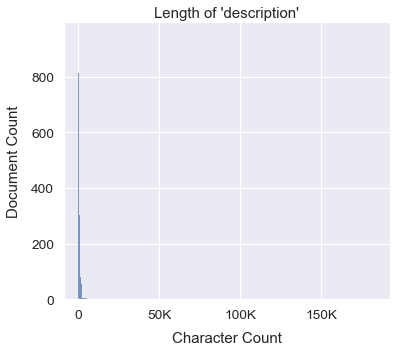

<IPython.core.display.Javascript object>

In [4]:
fig = lang.length_dist(df.sample(10000), subset=["description"])

In [5]:
lang.other.length_info(df)

        len_description  len_title  len_brand  len_price
min                   1          1          1          5
median              378         57         11          6
max             257,332      1,996      1,986      4,648


<IPython.core.display.Javascript object>

In [6]:
df = lang.trim_length_outliers(
    df,
    subset=["description"],
    q_lower=0.2,
    q_upper=0.99,
)
df.head()

        len_description
min                 135
median              490
max               3,883


             n_trimmed  pct_trimmed
description  1,696,694           21
title                0            0
brand                0            0
price                0            0
main_cat             0            0
total_obs    1,696,694           21


,description,title,brand,price,main_cat
asin,,,,,
B000052XWP,"advanced pain relief for the arch, heel, knee,...",dr scholls dyna step-women's,dr scholl's,None,all beauty
B00005NWS1,this electric shoe polisher has a high torque ...,first class electric shoe polisher,jerdon,None,all beauty
B000068DEG,bvlgari by bvlgari for women eau de parfum spr...,"bvlgari women eau de perfume, 1.7 fl. oz",bvlgari,None,all beauty
B00006IQ95,quick and convenient for easy touch-ups around...,mespirit eyebrows remover trimmer razor shaver...,la sante,None,all beauty
B000078OSM,carry your light travel necessities comfortabl...,"clava one pocket 20"" duffel (vachetta tan)",clava,$185.16,all beauty


<IPython.core.display.Javascript object>

In [7]:
df = lang.trim_length_outliers(
    df,
    subset=["title", "brand"],
    q_inner=0.99,
)
df.head()

        len_title  len_brand
min             8          2
median         59         11
max           218         42


             n_trimmed  pct_trimmed
description          0            0
title           62,722            1
brand           26,897            0
price                0            0
main_cat             0            0
total_obs       89,265            1


,description,title,brand,price,main_cat
asin,,,,,
B000052XWP,"advanced pain relief for the arch, heel, knee,...",dr scholls dyna step-women's,dr scholl's,None,all beauty
B00005NWS1,this electric shoe polisher has a high torque ...,first class electric shoe polisher,jerdon,None,all beauty
B000068DEG,bvlgari by bvlgari for women eau de parfum spr...,"bvlgari women eau de perfume, 1.7 fl. oz",bvlgari,None,all beauty
B00006IQ95,quick and convenient for easy touch-ups around...,mespirit eyebrows remover trimmer razor shaver...,la sante,None,all beauty
B000078OSM,carry your light travel necessities comfortabl...,"clava one pocket 20"" duffel (vachetta tan)",clava,$185.16,all beauty


<IPython.core.display.Javascript object>

In [ ]:
fig = lang.length_dist(df, subset=["description", "title", "brand"])

# Clean Price

In [8]:
df["price"] = df.loc[:, "price"].str.extract(r"\$?(\d+\.\d{2}|\d+)")
df["price"] = df.loc[:, "price"].astype(np.float64)
df.head(10)

,description,title,brand,price,main_cat
asin,,,,,
B000052XWP,"advanced pain relief for the arch, heel, knee,...",dr scholls dyna step-women's,dr scholl's,NaN,all beauty
B00005NWS1,this electric shoe polisher has a high torque ...,first class electric shoe polisher,jerdon,NaN,all beauty
B000068DEG,bvlgari by bvlgari for women eau de parfum spr...,"bvlgari women eau de perfume, 1.7 fl. oz",bvlgari,NaN,all beauty
B00006IQ95,quick and convenient for easy touch-ups around...,mespirit eyebrows remover trimmer razor shaver...,la sante,NaN,all beauty
B000078OSM,carry your light travel necessities comfortabl...,"clava one pocket 20"" duffel (vachetta tan)",clava,185.16,all beauty
B0000TIK8K,"traditional indiglo night-light, wr 30m, easy ...",timex children's watch t72891,timex,NaN,all beauty
B00012KBNS,the lady's watch has a .75 inch diameter face ...,timex indiglo watch ladies gold with expansion...,magnifying aids,99.95,all beauty
B000172RRG,overall protection for your hairstyle front br...,rain runner light blue,andre,NaN,all beauty
B000186WR6,"rich design, this stylish, polish finish, two-...",mens royal tel time bi color talking watch wit...,royal tel-time,49.95,all beauty


<IPython.core.display.Javascript object>

In [9]:
df.isna().sum() / df.shape[0]

description    0.000000
title          0.000000
brand          0.048635
price          0.459268
main_cat       0.000000
dtype: float64

<IPython.core.display.Javascript object>

# Clean Brand

In [10]:
brand_counts = df["brand"].value_counts()
brand_counts.head(15)

generic                 19520
unknown                 18196
uxcell                  17692
3drose                  13969
disney                  10168
various artists          7772
yu-gi-oh!                7400
sony                     7212
adidas                   7097
magic: the gathering     6782
invicta                  6547
samsung                  6369
hp                       5772
amscan                   5537
various                  5358
Name: brand, dtype: int64

<IPython.core.display.Javascript object>

In [11]:
null_brands = [
    "generic",
    "n/a",
    "na",
    "no",
    "no brand",
    "none",
    "not available",
    "null",
    "unavailable",
    "unbranded",
    "unknown",
    "learn more",
    "other",
    "anonymous",
]

brand_counts.loc[null_brands].sort_values()

unavailable          3
no                   5
no brand            15
null                33
unbranded          162
anonymous          186
not available      230
na                 270
learn more         305
other              355
n/a                831
none               969
unknown          18196
generic          19520
Name: brand, dtype: int64

<IPython.core.display.Javascript object>

In [12]:
df.loc[df.brand == "generic"]

,description,title,brand,price,main_cat
asin,,,,,
B007IS408A,"made of high-quality canvas, very light and du...",beyond border korean fashion men waist bag fan...,generic,NaN,all beauty
B00AYS2TMA,size: c package include: 1x silicone bra ( sel...,invisible self-adhesive strapless backless sil...,generic,NaN,all beauty
B00AYS2T2A,size: a package include: 1x silicone bra ( sel...,leegoal self adhesive nubra strapless sheer si...,generic,8.87,all beauty
B00GLJDNN0,"description it is a light and soft underwear,t...",generic women girls sexy lingeries sleepwear l...,generic,NaN,all beauty
B00HNKJUOC,"description: occasion: wedding, engagements,pr...",wedding bridal prom crystal rhinestone butterf...,generic,3.89,all beauty
...,...,...,...,...,...
B00W4PRT3U,"descriptions: cute cat paw design , enhance th...",generic cat paw analog joystick thumbstick gri...,generic,NaN,video games
B00WJGWIUS,"features: easy to install and dismantle, effec...",generic full housing shell case button kit rep...,generic,NaN,video games
B010YVWESK,new hd tv component composite audio video av c...,paladia new hd tv component composite audio vi...,generic,NaN,video games


<IPython.core.display.Javascript object>

In [13]:
if "generic" in null_brands:
    null_brands.remove("generic")
df.loc[df.brand.isin(null_brands), "brand"] = np.nan
df.isna().sum()

description          0
title                0
brand           327743
price          2891358
main_cat             0
dtype: int64

<IPython.core.display.Javascript object>

In [14]:
by_brands = df.brand.str.startswith("by ").dropna()
df.dropna().loc[by_brands, ["brand"]]

,brand
asin,
B00HN356DI,by unbra
B00KUSQ9NY,by alegory
B00K0SXUBS,by w5swl
B00XO7BFEQ,by nvidia
B001F64EQ4,by the cup
...,...
B000AXRIU2,by dreamcatcher games
B000B7PHLY,by value software
B000B7TFEY,by value software


<IPython.core.display.Javascript object>

In [15]:
df["brand"] = df.loc[:, "brand"].str.replace("^(by\s+)", "", regex=True)
df.dropna().loc[by_brands, ["brand"]]

,brand
asin,
B00HN356DI,unbra
B00KUSQ9NY,alegory
B00K0SXUBS,w5swl
B00XO7BFEQ,nvidia
B001F64EQ4,the cup
...,...
B000AXRIU2,dreamcatcher games
B000B7PHLY,value software
B000B7TFEY,value software


<IPython.core.display.Javascript object>

In [16]:
amazon_pages = df.brand.str.extract(r"visit amazon's (.+) page")
amazon_pages = amazon_pages.dropna().squeeze()
df.loc[amazon_pages.index, "brand"] = amazon_pages
df.loc[amazon_pages.index]

,description,title,brand,price,main_cat
asin,,,,,
0001050230,william shakespeare is widely regarded as the ...,love's labour's lost: performed by derek jacob...,william shakespeare,20.93,books
000105001X,"jo clifford, a successful journalist, is all s...",lady of hay,barbara erskine,NaN,books
0001047868,grade 6 up-kidnapped by robert louis stevenson...,kidnapped (harpercollinsaudiobooks),robert louis stevenson,NaN,books
000100039X,kahlil gibran was among the most important ara...,the prophet,kahlil gibran,NaN,books
0001049143,grade 7 up-scottish actor john cairney gives v...,the poems & songs of robert burns (harpercolli...,robert burns,NaN,books
...,...,...,...,...,...
B004APDZBM,this 3 volume series of wonderfully illustrate...,the art of making leather cases - 3 volume set,al stohlman,NaN,books
B00EEDQ30U,you can fit these potholder patterns into the ...,vintage floral potholders crochet patterns,maggie weldon,NaN,books
0310948827,if you want to prepare for (or are already in)...,the god of all comfort bible study guide: find...,dee brestin,31.25,books


<IPython.core.display.Javascript object>

In [17]:
regex = df.brand.value_counts().reset_index()
regex.columns = ["brand", "count"]
regex["brand"] = lang.strip_non_word(regex.loc[:, "brand"])
regex = regex.loc[
    (~regex.brand.str.contains("\s", regex=True))
    & (regex.brand != "various")
    & (regex.brand.str.len() > 3)
]
regex["brand"] = r"^" + regex.brand.map(re.escape) + r"\b"
regex.head(10)

,brand,count
0,^generic\b,19634
1,^uxcell\b,17699
2,^3drose\b,13969
3,^disney\b,10198
4,^sony\b,7886
7,^adidas\b,7097
9,^invicta\b,6547
10,^samsung\b,6371
12,^amscan\b,5537
15,^nike\b,5269


<IPython.core.display.Javascript object>

In [18]:
regex = regex.loc[:, "brand"].head(20)
regex

0      ^generic\b
1       ^uxcell\b
2       ^3drose\b
3       ^disney\b
4         ^sony\b
7       ^adidas\b
9      ^invicta\b
10     ^samsung\b
12      ^amscan\b
15        ^nike\b
19    ^majestic\b
21        ^dell\b
23      ^mattel\b
24     ^beistle\b
25     ^pokemon\b
26        ^lego\b
27      ^hasbro\b
29      ^empire\b
33      ^darice\b
35      ^reebok\b
Name: brand, dtype: object

<IPython.core.display.Javascript object>

In [19]:
missing_brand = df.loc[df.brand.isna()]
fillers = lang.locate_patterns(regex, missing_brand.title, exclusive=True)
fillers

asin
024129505X      lego
0736402012    disney
0786832924    disney
0786835850    disney
1405288027      lego
               ...  
B01HJB1QEG    adidas
B01HJCYJQM    adidas
B01HJDV7HK    adidas
B01HJDVCJI    adidas
B01HJDW6ZC    adidas
Name: locate_patterns, Length: 22953, dtype: object

<IPython.core.display.Javascript object>

In [20]:
df.loc[fillers.index, "brand"] = fillers
df.loc[fillers.index]

,description,title,brand,price,main_cat
asin,,,,,
024129505X,"a brand-new lego city adventure about thieves,...",lego city: bulldozer break-in,lego,8.55,books
0736402012,from disney winnie the poohs sweet dreams book...,"disney's one, two, pooh's looking for you (swe...",disney,22.79,books
0786832924,magic is everywhere if you know where to look....,disney's add a little magic: words of inspiration,disney,18.88,books
0786835850,inside kim possible's very first badical boxed...,disney's kim possible: badical - books #1-4 bo...,disney,35.00,books
1405288027,what would you do if you were famous? what's y...,lego (r) ninjago: book of secrets,lego,14.30,books
...,...,...,...,...,...
B01HJB1QEG,in 1991 the equipment running shoe stepped ont...,adidas originals women's equipment support adv...,adidas,98.75,amazon fashion
B01HJCYJQM,these running-inspired low tops match clean de...,"adidas originals men's x_plr sneakers, lightwe...",adidas,33.95,amazon fashion
B01HJDV7HK,an edgy take on adidas running-inspired herita...,adidas originals men's tubular shadow knit fas...,adidas,93.98,amazon fashion


<IPython.core.display.Javascript object>

In [21]:
df.isna().sum()

description          0
title                0
brand           304790
price          2891358
main_cat             0
dtype: int64

<IPython.core.display.Javascript object>

In [22]:
df = df.dropna(subset=["brand"])
df.shape

(5990784, 5)

<IPython.core.display.Javascript object>

## Revisit Main Categories

In [23]:
df = utils.prune_categories(df, "main_cat", cut=1000)
df["main_cat"].value_counts()

                        Dropped
handmade                      2
luxury beauty                13
magazine subscriptions      711


books                           1215259
amazon home                      891352
amazon fashion                   693327
sports & outdoors                459051
toys & games                     343662
tools & home improvement         325844
automotive                       322586
grocery                          213847
cell phones & accessories        186793
digital music                    174645
computers                        131705
office products                  130659
arts, crafts & sewing            128890
pet supplies                     108244
industrial & scientific          105528
all electronics                   95336
movies & tv                       89554
camera & photo                    74788
musical instruments               67374
home audio & theater              65569
health & personal care            37988
video games                       35234
baby                              21443
all beauty                        18953
car electronics                   16744


<IPython.core.display.Javascript object>

# Add Subcategory Info

In [24]:
subcats = pd.read_parquet(
    "data/init_dropna", engine="pyarrow", columns=["category", "asin"]
)
subcats.set_index("asin", inplace=True)
subcats = subcats.loc[df.index].dropna().squeeze()
subcats

asin
B000052XWP    [Clothing, Shoes & Jewelry, Women, Shoes, Sand...
B000052XWP    [Clothing, Shoes & Jewelry, Women, Shoes, Sand...
B00005NWS1    [Clothing, Shoes & Jewelry, Shoe, Jewelry & Wa...
B00005NWS1    [Clothing, Shoes & Jewelry, Shoe, Jewelry & Wa...
B000068DEG    [Clothing, Shoes & Jewelry, Novelty & More, Cl...
                                    ...                        
B00ZOGIMZ0    [Software, Music, MP3 Editing & Effects, MP3 S...
B015ONJ9KO    [Software, Digital Software, Music, CD Burning...
B015ONXBXA    [Software, Digital Software, Music, CD Burning...
B015OOLJ3I    [Software, Digital Software, Lifestyle & Hobbi...
B01DTJYXEW    [Software, Digital Software, Design & Illustra...
Name: category, Length: 5835320, dtype: object

<IPython.core.display.Javascript object>

In [25]:
subcats = subcats.explode()
filts = [lang.decode_html_entities, lang.lowercase, lang.strip_html_tags]
for filt in filts:
    subcats = filt(subcats)
subcats

asin
B000052XWP                            clothing, shoes & jewelry
B000052XWP                                                women
B000052XWP                                                shoes
B000052XWP                                              sandals
B000052XWP                            clothing, shoes & jewelry
                                    ...                        
B01DTJYXEW    architectural drawings - draw professional-qua...
B01DTJYXEW    engineering layouts - double-precision accurac...
B01DTJYXEW    shop drawings - entering specific values for d...
B01DTJYXEW    home projects - create do-it-yourself landscap...
B01DTJYXEW    other cad needs - create electronic schematics...
Name: category, Length: 26019512, dtype: object

<IPython.core.display.Javascript object>

In [26]:
subcats = lang.trim_length_outliers(subcats, q_inner=0.9)
subcats.head()

        category
min            5
median        15
max           38


           n_trimmed  pct_trimmed
category   2,028,580            8
total_obs  2,028,580            8


asin
B000052XWP    clothing, shoes & jewelry
B000052XWP                        women
B000052XWP                        shoes
B000052XWP                      sandals
B000052XWP    clothing, shoes & jewelry
Name: category, dtype: object

<IPython.core.display.Javascript object>

Next I drop duplicate subcategories (relative to each product).

In [27]:
subcats = subcats.reset_index().drop_duplicates()
subcats = subcats.set_index("asin").squeeze()
subcats

asin
B000052XWP    clothing, shoes & jewelry
B000052XWP                        women
B000052XWP                        shoes
B000052XWP                      sandals
B00005NWS1    clothing, shoes & jewelry
                        ...            
B015OOLJ3I          lifestyle & hobbies
B015OOLJ3I                 scrapbooking
B01DTJYXEW                     software
B01DTJYXEW             digital software
B01DTJYXEW        design & illustration
Name: category, Length: 23479537, dtype: object

<IPython.core.display.Javascript object>

In [28]:
subcats = utils.implode(subcats)
subcats.head()

asin
0000012300    [sports & outdoors, outdoor recreation, campin...
0000098906    [musical instruments, drums & percussion, hand...
0000143502                                [movies & tv, movies]
0000143529                                [movies & tv, movies]
0000143588                                [movies & tv, movies]
Name: category, dtype: object

<IPython.core.display.Javascript object>

In [29]:
df = pd.merge(df, subcats, left_index=True, right_index=True, how="left")
df = df.rename(columns={"category": "sub_cat"})
df.head()

,description,title,brand,price,main_cat,sub_cat
asin,,,,,,
B000052XWP,"advanced pain relief for the arch, heel, knee,...",dr scholls dyna step-women's,dr scholl's,NaN,all beauty,"[clothing, shoes & jewelry, women, shoes, sand..."
B00005NWS1,this electric shoe polisher has a high torque ...,first class electric shoe polisher,jerdon,NaN,all beauty,"[clothing, shoes & jewelry, shoe, jewelry & wa..."
B000068DEG,bvlgari by bvlgari for women eau de parfum spr...,"bvlgari women eau de perfume, 1.7 fl. oz",bvlgari,NaN,all beauty,"[clothing, shoes & jewelry, novelty & more, cl..."
B00006IQ95,quick and convenient for easy touch-ups around...,mespirit eyebrows remover trimmer razor shaver...,la sante,NaN,all beauty,"[clothing, shoes & jewelry, women, clothing, l..."
B000078OSM,carry your light travel necessities comfortabl...,"clava one pocket 20"" duffel (vachetta tan)",clava,185.16,all beauty,"[clothing, shoes & jewelry, luggage & travel g..."


<IPython.core.display.Javascript object>

In [30]:
del subcats

<IPython.core.display.Javascript object>

# Add 'feature' text

In [31]:
feat = pd.read_parquet(
    "data/init_dropna", engine="pyarrow", columns=["feature", "asin"]
)
feat.set_index("asin", inplace=True)
feat = feat.loc[df.index].dropna().squeeze()
feat

asin
B000078OSM    [Front exterior zipper pocket, Fully-lined int...
B000078OSM    [Front exterior zipper pocket, Fully-lined int...
B0002YE8VQ    [Man made, Kitty Cat Felt with Satin Bow on th...
B0002YE8VQ    [Man made, Kitty Cat Felt with Satin Bow on th...
B0009LHRLK    [leather, zipper closure, Roomy interior, Full...
                                    ...                        
B00ZOGIMZ0    [Brand new and high quality, compatible with: ...
B015ONJ9KO    [Music for Free from the Internet: Get the cur...
B015ONXBXA    [Video Stream Recorder: Record all major video...
B015OOLJ3I    [Music Stream Recorder with Turbo Speed: Recor...
B01DTJYXEW    [Architectural Drawings - Draw professional-qu...
Name: feature, Length: 3990231, dtype: object

<IPython.core.display.Javascript object>

In [32]:
feat = feat.str.join(" ")
filts = [lang.decode_html_entities, lang.lowercase, lang.strip_html_tags]
for filt in filts:
    feat = filt(feat)
feat

asin
B000078OSM    front exterior zipper pocket fully-lined inter...
B000078OSM    front exterior zipper pocket fully-lined inter...
B0002YE8VQ    man made kitty cat felt with satin bow on the ...
B0002YE8VQ    man made kitty cat felt with satin bow on the ...
B0009LHRLK    leather zipper closure roomy interior fully-li...
                                    ...                        
B00ZOGIMZ0    brand new and high quality, compatible with: m...
B015ONJ9KO    music for free from the internet: get the curr...
B015ONXBXA    video stream recorder: record all major video ...
B015OOLJ3I    music stream recorder with turbo speed: record...
B01DTJYXEW    architectural drawings - draw professional-qua...
Name: feature, Length: 3990231, dtype: object

<IPython.core.display.Javascript object>

In [33]:
lang.length_info(feat)

        len_feature
min               0
median          280
max          77,138


<IPython.core.display.Javascript object>

In [34]:
feat.loc[feat.str.len().idxmax()]

'cra-z-art cra-z-loom ultimate color craze refill over 2000 pieces ultimate color craze cra-z-loom bracelet maker rubber bands and "s" clips latex free use with cra-z-loom tm to make fun rubber band accessories! recommended ages: 3 years and up product measures: 10.25" x 8.25" x 1.5" #productdescription { color: #333333; word-wrap: break-word; font-size: small; line-height: initial; margin: 0.5em 0px 0em 25px; } #productdescription_feature_div > h2.default { color: #cc6600; font-size: medium; margin: 0 0 0.25em; } #productdescription_feature_div > h2.books { color:#333 !important; font-size:21px !important; line-height: 1.3; padding-bottom: 4px; font-weight: normal; margin: 0px; } #productdescription_feature_div > h2.softlines { color:#333 !important; font-size:21px !important; line-height: 1.3; padding-bottom: 4px; font-weight: bold; margin: 0px; } #productdescription > p, #productdescription > div, #productdescription > table { margin: 0 0 1em 0; } #productdescription p { margin: 0em

<IPython.core.display.Javascript object>

In [35]:
feat = lang.trim_length_outliers(feat, q_inner=0.98)
feat.head()

        len_feature
min              17
median          280
max           1,905


           n_trimmed  pct_trimmed
feature       79,733            2
total_obs     79,733            2


asin
B000078OSM    front exterior zipper pocket fully-lined inter...
B000078OSM    front exterior zipper pocket fully-lined inter...
B0002YE8VQ    man made kitty cat felt with satin bow on the ...
B0002YE8VQ    man made kitty cat felt with satin bow on the ...
B0009LHRLK    leather zipper closure roomy interior fully-li...
Name: feature, dtype: object

<IPython.core.display.Javascript object>

In [36]:
feat.loc[feat.str.len().idxmax()]

'dual camera, dual safeguard! easier for back your car. both the front and rear camera can record and save videos simultaneously. the screen of this dvr provides a clearer view and better images and details for the playback whether in the dvr or computer. from the video file, you would find the license plate number very clear even in the evening or in the rain. 32gb tf card can store about 10 hours of videos and the loop record makes no wasted spaces. superior night vision! h.264 video format and cmos sensor is perfect for the night mode. the superior 7-glass lenses and six assisting led could help the camera save clearer video in a poor light condition. allwinner a20 chipset + nt99141 sensor. what is g-sensor? when your car is being collided or shocked, the camera recorder would lock the current video file and protect it from being deleted or covered. therefore, when a car accident occurs to your car unfortunately, this camera recorder will save the proof for you at once. the sensitiv

<IPython.core.display.Javascript object>

In [37]:
df = pd.merge(df, feat, left_index=True, right_index=True, how="left")
df.head()

,description,title,brand,price,main_cat,sub_cat,feature
asin,,,,,,,
0000012300,deluxe duffel bag with full length zipper desi...,6ft of acid free linen tape for bookbinding,stansport,4.00,sports & outdoors,"[sports & outdoors, outdoor recreation, campin...",cotton canvas acid free
0000044806,ayurveda holds secrets for all our skin proble...,medimix ayurvedic facewash - 100 ml (pack of 2),medimix,16.80,health & personal care,NaN,NaN
0000060259,if you feel that applying powder kumkum is tir...,lakme jewel sindoor (maroon) - pack of 2,lakme,7.99,health & personal care,NaN,NaN
0000098906,frog - rubbing its spine with the wooden stick...,"wooden percussion 3 piece set frog, cricket an...",wadsuwan shop,0.91,musical instruments,"[musical instruments, drums & percussion, hand...",wood percussion small 3 inches creates origina...
0000143502,rise and swine (good eats vol. 7) includes bon...,rise and swine (good eats vol. 7),alton brown,NaN,movies & tv,"[movies & tv, movies]",NaN


<IPython.core.display.Javascript object>

In [38]:
df = utils.prune_categories(df, column="main_cat", cut=1000)
df.head()

No categories dropped.


,description,title,brand,price,main_cat,sub_cat,feature
asin,,,,,,,
0000012300,deluxe duffel bag with full length zipper desi...,6ft of acid free linen tape for bookbinding,stansport,4.00,sports & outdoors,"[sports & outdoors, outdoor recreation, campin...",cotton canvas acid free
0000044806,ayurveda holds secrets for all our skin proble...,medimix ayurvedic facewash - 100 ml (pack of 2),medimix,16.80,health & personal care,NaN,NaN
0000060259,if you feel that applying powder kumkum is tir...,lakme jewel sindoor (maroon) - pack of 2,lakme,7.99,health & personal care,NaN,NaN
0000098906,frog - rubbing its spine with the wooden stick...,"wooden percussion 3 piece set frog, cricket an...",wadsuwan shop,0.91,musical instruments,"[musical instruments, drums & percussion, hand...",wood percussion small 3 inches creates origina...
0000143502,rise and swine (good eats vol. 7) includes bon...,rise and swine (good eats vol. 7),alton brown,NaN,movies & tv,"[movies & tv, movies]",NaN


<IPython.core.display.Javascript object>

# Export

In [39]:
path = "data/amazon_clean"
if os.path.isdir(path):
    shutil.rmtree(path)

df.to_parquet(
    path,
    engine="pyarrow",
    index=True,
    partition_cols=["main_cat"],
)

<IPython.core.display.Javascript object>